In [4]:
# plot DY vs. signal distributions

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [5]:
fpath =OrderedDict()
tree = OrderedDict()


ver = 'V1p17'
sig_ver = 'v14'

dy_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'
sig_path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/analyzers/'



lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
lumi = 41.53*1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath['mc_signal'] = sig_path+"ggH_HToSSTobbbb_MH-125_2017_allpoints.root"
fpath['dy'] = dy_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'




lumi is 41.53 fb-1


In [6]:
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    a = tree[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc_signal /storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/analyzers/ggH_HToSSTobbbb_MH-125_2017_allpoints.root
[-1.0533807  -1.0517426  -1.0512415  -1.0415096  -1.0310946  -1.0278105
 -1.0258878  -1.0228117  -1.0207764  -1.0011775  -0.9895574   0.97966176
  0.9895574   0.99116576  1.0011775   1.0054727   1.0105685   1.0125835
  1.0156289   1.0175322   1.0207764   1.0207835   1.0228117   1.0258878
  1.0278105   1.0310946   1.0324185   1.032691    1.040729    1.0412251
  1.0415096   1.0428469   1.0431222   1.0512415   1.0517426   1.0533807 ]
(330277,)
dy /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v14/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
[-8.627941  -1.2055961 -0.1042499  0.1042499  1.2055961  8.627941 ]
(162960,)


# load BDT

In [7]:
import pandas as pd
import pickle

bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3'
bdt_cut = 0.28675458
model = pickle.load(open(bdt_name+'.pickle', "rb" ))


In [8]:
rechit_cut = {}
rechit_cut['v11'] = 50

rechit_cut['v14'] = 50
rechit_cut['v15'] = 40
rechit_cut['v16'] = 60
rechit_cut['v17'] = 70
rechit_cut['v18'] = 30
rechit_cut['v24'] = 130


rechit_cut['v19'] = 50
rechit_cut['v20'] = 50
rechit_cut['v21'] = 50
rechit_cut['v22'] = 50
rechit_cut['v23'] = 50



### Cluster efficiency

In [9]:
%%time

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
cscRechitClusterEta = {}
cscRechitClusterSize = {}
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
mc_corr_weight = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
lepSF = {}
cond = {}
cscRechitClusterEta = {}
sel_tp = {}
bdt_score = {}
cut_based = {}
id_eff = {}
nrechits_eff = {}
id_wrt_nrechit = {}
muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]

for k, T in tree.items():
    if k == "mc_signal":
        sel_ev[k] = T.array('nCscRechitClusters') > 0
        cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_ev[k]][:,0]
        cscRechitClusterSize[k] = T.array('cscRechitClusterSize')[sel_ev[k]][:,0]
        cscRechitClusterNStation10[k] = T.array('cscRechitClusterNStation10')[sel_ev[k]][:,0]
        cscRechitClusterAvgStation10[k] = T.array('cscRechitClusterAvgStation10')[sel_ev[k]][:,0]
        weight[k] = T.array('weight')*lumi
        pileupWeight[k] = T.array('pileupWeight')
    else:
        ########## select cluster ########
        print("here")
        sel_cluster = np.abs(T.array('cscRechitCluster3Time')) < 12.5

        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Size'))>=50)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3TimeSpread'))<20)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MaxChamber')) > 12)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Eta')) < 2.0)    
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MuonVetoPt')) > muonPt)
        sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('cscRechitCluster3ZLep1') == 1, T.array('cscRechitCluster3ZLep2') == 1))
        if k[:2] == 'dy':sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster3GenMuonVetoPt') > muonPt)
        if tag_probe: 
            sel_cluster1 =np.logical_and(sel_cluster,  T.array('cscRechitCluster3ZLep1') == 1)   #loose lepton
            sel_cluster2 = np.logical_and(sel_cluster,  T.array('cscRechitCluster3ZLep2') == 1)  
        print("here")
        # ########### BRANCHES ############
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])

        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<800)
    #         sel_ev[k] = np.logical_and(sel_ev[k], T.array('nCscRechitClusters3')>0)

        probe_index[k] = []
        sel_tp[k] = []
        cond[k] = []
        sel_probecluster = []
        pdgid = T.array("lepPdgId")


        index = 0
        for i, ev in enumerate(sel_ev[k]):
            if ev:
                if sel_lep[k][i][0]:
                    probe_index[k].append([False,True])
                    sel_tp[k].append(index)
                    if pdgid[i][0] == 13:
                        cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                        if cond[k][-1]: sel_probecluster.append(list(sel_cluster2[i]))
                    else:
                        cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
                if sel_lep[k][i][1]:
                    probe_index[k].append([True, False])
                    sel_tp[k].append(index)
                    if pdgid[i][0] == -13:
                        cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster2[i]))
                    else:
                        cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
                index+=1
        sel_tp[k] = np.array(sel_tp[k])
        probe_index[k] = np.array(probe_index[k])
        cond[k] = np.array(cond[k])
        sel_probecluster = awkward.fromiter(sel_probecluster)

        weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
        if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]]
    #         if k[:2] == 'dy': lepOverallSF[k] = pileupWeight[k]*0.0+1.0



        ZMass[k]= T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]][sel_tp[k]]
        mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        # with pT > 50
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247


        lepE[k] = np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepEta[k] = np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepPt[k] = np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]])[probe_index[k]]

        if k[:2] == 'dy':lepSF[k] = np.array(T.array('lepSF')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
    #         if k[:2] == 'dy':lepSF[k] = lepPt[k]*0.0+1.0


        if k[:4] == 'data':
            pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
            weight[k] = weight[k] * 0.0 + 1.0
            mc_corr_weight[k] = weight[k] * 0.0 + 1.0

        cscRechitClusterEta[k] = awkward.fromiter(T.array('cscRechitCluster3Eta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterSize[k] = awkward.fromiter(T.array('cscRechitCluster3Size')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterNStation10[k] = awkward.fromiter(T.array('cscRechitCluster3NStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterAvgStation10[k] = awkward.fromiter(T.array('cscRechitCluster3AvgStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        print(k, "here")

    if bdt_name =='bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3':
        bdt_var = {'cscRechitClusterNStation10': cscRechitClusterNStation10[k],
        'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
        'cscRechitClusterAvgStation10':np.abs(cscRechitClusterAvgStation10[k]),
    }
    print(k, "here")
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1] 
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    cut_based[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    total_weight = weight[k]*pileupWeight[k]
    if k[:2] == 'dy': total_weight *= lepOverallSF[k]*mc_corr_weight[k]
    if k[:2] == 'dy': total_weight = total_weight[cond[k]]
    id_eff[k] = np.sum(total_weight[cut_based[k]])/np.sum(total_weight)


    nrechits_eff[k] =  np.sum(total_weight[cscRechitClusterSize[k]>=130])/np.sum(total_weight)
    id_wrt_nrechit[k] = np.sum(total_weight[np.logical_and(cscRechitClusterSize[k]>=130, cut_based[k])])/np.sum(total_weight[cscRechitClusterSize[k]>=130])

print('id uncertainty', id_eff['mc_signal'], id_eff['dy'])
print('id wrt nrechits uncertainty', id_wrt_nrechit['mc_signal'], id_wrt_nrechit['dy'])
print('nrechits uncertainty', nrechits_eff['mc_signal'], nrechits_eff['dy'])




#     print(m1,m2, len(weight['data']), np.sum(weight['data']*pileupWeight['data'])/np.sum(lepOverallSF['dy_'+m1+'_'+m2]* weight['dy_'+m1+'_'+m2]*pileupWeight['dy_'+m1+'_'+m2]))



mc_signal here
here
here
dy here
dy here
id uncertainty 0.81554127 0.7487976
id wrt nrechits uncertainty 0.80701995 0.7110858
nrechits uncertainty 0.7829972 0.10840015
CPU times: user 27.8 s, sys: 428 ms, total: 28.2 s
Wall time: 22.5 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/sig_DYMC_compare/cscRechitClusterEta.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/sig_DYMC_compare/cscRechitClusterEta.C has been generated
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/sig_DYMC_compare/cscRechitClusterEta_log.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/sig_DYMC_compare/cscRechitClusterEta_log.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: R

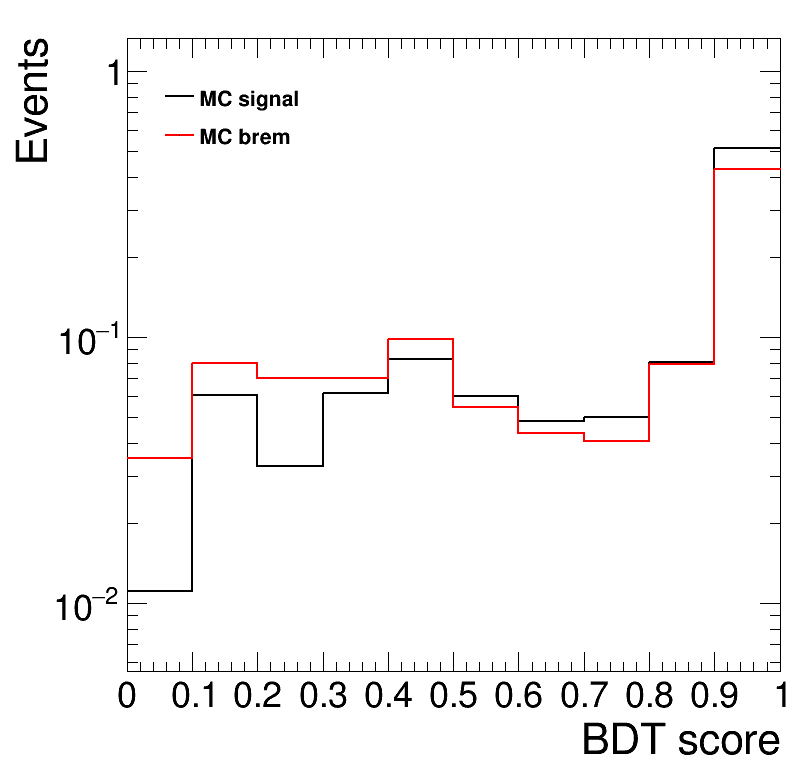

In [40]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
var = [cscRechitClusterEta, cscRechitClusterNStation10, cscRechitClusterAvgStation10, cscRechitClusterSize, bdt_score]
title = [ 'cluster #eta', 'N_{station}', 'Avg Station', 'N_{rechits}', 'BDT score']
bins = [  [12,0.8,2.0], [5,0,5], [20,0,5], [0, 50, 70, 100, 150, 250, 500], [10,0,1]]
names = [ 'cscRechitClusterEta', 'cscRechitClusterNStation10', 'cscRechitClusterAvgStation10', 'cscRechitClusterSize', 'bdtScore']

assert(len(var) == len(title) == len(names) == len(bins) )

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/sig_DYMC_compare/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)


for j in range(len(bins)):
#     if not j == 3: continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.2,0.80,0.4,0.90)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    hm = {}
    hb = {}

    for i, k in enumerate(tree.keys()):
        total_weight = weight[k]*pileupWeight[k]
        if k[:2] == 'dy': 
            total_weight *= lepOverallSF[k]*mc_corr_weight[k]
            total_weight = total_weight[cond[k]]
            
        hm[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight)
        hm[k].SetLineColor(std_color_list[i])
        hm[k].Scale(1./hm[k].Integral())
        if k[:2] == 'dy': leg.AddEntry(hm[k], 'MC brem')
        else:leg.AddEntry(hm[k], 'MC signal')
        hm[k].Draw('hist same')
#     c = make_ratio_plot([hm['dy'],hm['mc_signal']], fit = False, logy=False, in_tags = ["MC brem","MC signal"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    hm['mc_signal'].SetMaximum(1.3*max(hm['dy'].GetMaximum(),hm['mc_signal'].GetMaximum() ))

    leg.Draw()
    c.Draw()
    c.SaveAs(dir_name+names[j]+".png")
    c.SaveAs(dir_name+names[j]+".C")

    if j == 1: hm['mc_signal'].SetMaximum(6*max(hm['dy'].GetMaximum(),hm['mc_signal'].GetMaximum() ))
    else: hm['mc_signal'].SetMaximum(2*max(hm['dy'].GetMaximum(),hm['mc_signal'].GetMaximum() ))


    c.SetLogy()
    c.Draw()
    c.SaveAs(dir_name+names[j]+"_log.png")
    c.SaveAs(dir_name+names[j]+"_log.C")